In [79]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

In [80]:
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/Cellar/enchant/2.7.3/lib'
import enchant
print("DYLD_LIBRARY_PATH:", os.getenv("DYLD_LIBRARY_PATH"))

DYLD_LIBRARY_PATH: /opt/homebrew/Cellar/enchant/2.7.3/lib


In [81]:
def read_corpus_to_dataframe(filepath):
    data = []
    sentence_id = 0  # Initialize sentence_id
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line.startswith('# sent_enum'):
                sentence_id = int(line.split('=')[1].strip())  # Update sentence_id based on the file
            elif line:  # Avoid empty lines
                parts = line.split('\t')
                if len(parts) == 2:
                    token, label = parts
                    data.append({'sentence_id': sentence_id, 'token': token, 'label': label})
    return pd.DataFrame(data)


In [82]:
df_train = read_corpus_to_dataframe('./data/es-en/train.conll')
df_dev = read_corpus_to_dataframe('./data/es-en/dev.conll')


In [83]:
english_dict = enchant.Dict("en_US")
def extract_features(df):
    features_list = []
    for _, sentence in df.groupby('sentence_id'):
        sentence_features = []
        tokens = sentence['token'].tolist()  # Get all tokens in the sentence as a list for easier indexing
        for i, (index, row) in enumerate(sentence.iterrows()):
            token = row['token']
            features = {
                'word': token,
                'prev_word': tokens[i - 1] if i > 0 else '',
                'next_word': tokens[i + 1] if i < len(tokens) - 1 else '',
                'is_english': english_dict.check(token),
                'word_length': len(token),
                'is_upper': token[0].isupper()
            }
            sentence_features.append(features)
        features_list.append(sentence_features)
    return features_list


In [84]:
print("Sample data from df_train:", df_train.head())
print("Sample data from df_dev:", df_dev.head())
print("Features for the first sample:", X_train[0])
print("Labels for the first sample:", y_train[0])


Sample data from df_train:    sentence_id  token  label
0            1  11:11  other
1            1  .....  other
2            1   make  lang1
3            1      a  lang1
4            1   wish  lang1
Sample data from df_dev:    sentence_id                   token  label
0            1               @_easanti  other
1            1            @mememecaigo  other
2            1  #todossomoscarlosperez  mixed
3            1           #hashtaglargo  lang2
4            2                       I  lang1
Features for the first sample: [{'word': '11:11', 'prev_word': '', 'next_word': '.....', 'is_english': False, 'word_length': 5, 'is_upper': False}, {'word': '.....', 'prev_word': '11:11', 'next_word': 'make', 'is_english': False, 'word_length': 5, 'is_upper': False}, {'word': 'make', 'prev_word': '.....', 'next_word': 'a', 'is_english': True, 'word_length': 4, 'is_upper': False}, {'word': 'a', 'prev_word': 'make', 'next_word': 'wish', 'is_english': True, 'word_length': 1, 'is_upper': False}, {

In [85]:
# verify that the number of features and labels are the same
for features, labels in zip(X_train, y_train):
    if len(features) != len(labels):
        print("Mismatch in number of features and labels")


In [86]:
# Extract features for training and development data
X_train = extract_features(df_train)
X_dev = extract_features(df_dev)
y_train = df_train.groupby('sentence_id')['label'].apply(list).tolist()
y_dev = df_dev.groupby('sentence_id')['label'].apply(list).tolist()

In [96]:
X_train[0], y_train[0]

([{'word': '11:11',
   'prev_word': '',
   'next_word': '.....',
   'is_english': False,
   'word_length': 5,
   'is_upper': False},
  {'word': '.....',
   'prev_word': '11:11',
   'next_word': 'make',
   'is_english': False,
   'word_length': 5,
   'is_upper': False},
  {'word': 'make',
   'prev_word': '.....',
   'next_word': 'a',
   'is_english': True,
   'word_length': 4,
   'is_upper': False},
  {'word': 'a',
   'prev_word': 'make',
   'next_word': 'wish',
   'is_english': True,
   'word_length': 1,
   'is_upper': False},
  {'word': 'wish',
   'prev_word': 'a',
   'next_word': '.......',
   'is_english': True,
   'word_length': 4,
   'is_upper': False},
  {'word': '.......',
   'prev_word': 'wish',
   'next_word': 'night',
   'is_english': False,
   'word_length': 7,
   'is_upper': False},
  {'word': 'night',
   'prev_word': '.......',
   'next_word': 'night',
   'is_english': True,
   'word_length': 5,
   'is_upper': False},
  {'word': 'night',
   'prev_word': 'night',
   'next_w

In [87]:
def train_crf(X_train, y_train):
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)
    return crf

In [88]:
crf_model = train_crf(X_train, y_train)
predictions = crf_model.predict(X_dev)

In [89]:
# Flatten the list of lists
if all(isinstance(pred, list) for pred in predictions):
    flat_predictions = [label for sublist in predictions for label in sublist]
else:
    flat_predictions = predictions

#check if the lengths match
if len(y_dev) != len(flat_predictions):
    print("Mismatch in lengths after flattening:")
    print("Length of y_dev:", len(y_dev))
    print("Length of flat_predictions:", len(flat_predictions))
else:
    print("Lengths match. Ready to compute confusion matrix.")


Mismatch in lengths after flattening:
Length of y_dev: 3332
Length of flat_predictions: 40391


In [90]:
#check if the lengths match
flat_y_dev = [label for sublist in y_dev for label in sublist] if isinstance(y_dev[0], list) else y_dev

if len(flat_y_dev) != len(flat_predictions):
    print("Mismatch in lengths after flattening y_dev:")
    print("Length of flat_y_dev:", len(flat_y_dev))
    print("Length of flat_predictions:", len(flat_predictions))
else:
    print("Lengths match. Ready to compute confusion matrix.")


Lengths match. Ready to compute confusion matrix.


In [91]:
# Compute confusion matrix
report = classification_report(flat_y_dev, flat_predictions, digits=2)

print("Classification Report:")
print(report)

accuracy = accuracy_score(flat_y_dev, flat_predictions)
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

   ambiguous       0.00      0.00      0.00        39
          fw       0.00      0.00      0.00         2
       lang1       0.97      0.98      0.97     16712
       lang2       0.95      0.98      0.96     14955
       mixed       0.00      0.00      0.00         6
          ne       0.83      0.44      0.57       815
       other       0.97      0.96      0.97      7830
         unk       0.75      0.09      0.17        32

    accuracy                           0.96     40391
   macro avg       0.56      0.43      0.46     40391
weighted avg       0.96      0.96      0.96     40391

Accuracy: 0.9610804387115942


/Users/keming/miniconda3/envs/extra_info/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/keming/miniconda3/envs/extra_info/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/keming/miniconda3/envs/extra_info/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

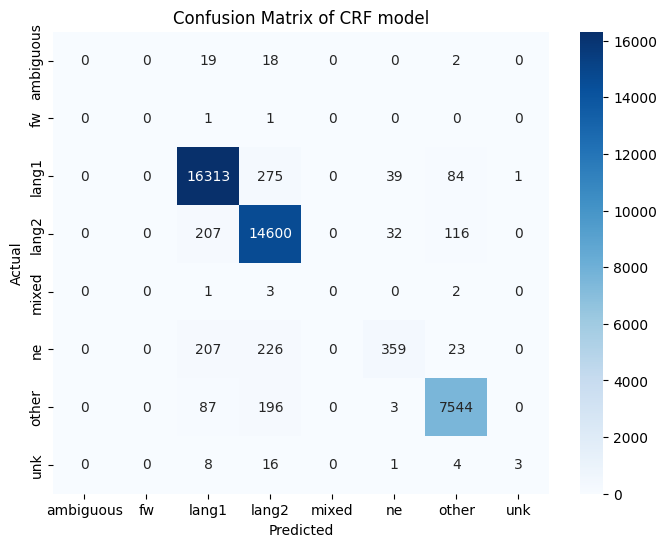

In [92]:
def evaluate_and_plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = np.unique(np.concatenate((y_true, y_pred)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix of CRF model')
    plt.show()

evaluate_and_plot_confusion_matrix(flat_y_dev, flat_predictions)


In [93]:
import pickle
with open("model_crf", "wb") as f:
    pickle.dump(crf_model, f)

with open("model_crf", "rb") as f:
    loaded_model = pickle.load(f)


In [95]:
def extract_features(sentence):
#test        
    sentence_features = []
    tokens = [word for word in sentence.split() if word.strip()]  # 分词
    for i, token in enumerate(tokens):
        features = {
            'word': token,
            'prev_word': tokens[i - 1] if i > 0 else '',
            'next_word': tokens[i + 1] if i < len(tokens) - 1 else '',
            'is_english': english_dict.check(token),
            'word_length': len(token),
            'is_upper': token[0].isupper()
        }
        sentence_features.append(features)
    return [sentence_features]

with open("model_crf.pkl", "rb") as f:
    loaded_model = pickle.load(f)

def predict_sentence(sentence):
    features = extract_features(sentence)
    prediction = loaded_model.predict(features)
    return prediction

def read_and_predict(filepath):
    predictions = []
    with open(filepath, 'r', encoding='utf-8') as file:
        sentence = []
        for line in file:
            line = line.strip()
            if line:
                sentence.append(line)
            else:  
                if sentence:
                    prediction = predict_sentence(' '.join(sentence))
                    predictions.append(prediction)
                    sentence = []  # 重置句子
        if sentence:  
            prediction = predict_sentence(' '.join(sentence))
            predictions.append(prediction)
    return predictions


test_predictions = read_and_predict('./data/es-en/test.conll')
print(test_predictions)

[[['lang2', 'lang2', 'lang2', 'lang2']], [['other', 'other', 'other', 'other', 'lang2', 'lang2', 'lang2', 'lang2', 'other', 'lang2', 'lang2', 'lang2', 'lang2', 'other', 'other', 'lang2', 'other', 'lang2']], [['lang2', 'lang2', 'lang2', 'other', 'other', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'other', 'lang2', 'lang2', 'other', 'other', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'other']], [['lang2', 'other']], [['other', 'lang1', 'lang1', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'lang2', 'lang1', 'lang1', 'lang1', 'lang1', 'lang1', 'lang1', 'lang1', 'lang1', 'lang1', 'other', 'lang2', 'lang2']], [['other', 'other', 'other']], [['other']], [['other', 'other']], [['other']], [['other', 'other']], [['lang2', 'other']], [['other']], [['other', 'other']], [['other', 'other']], [['lang2']], [['other']], [['other', 'other']], [['other', 'other']], [['other', 'other', 'other']], [['other']], [['other', 'other']], [['other', 'other']], [['lang2', 